In [2]:
#%pip install 


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# avoid displaying warnings
import warnings
warnings.filterwarnings("ignore")


import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
#import plotly.offline as pyoff
import plotly.graph_objs as go 
#import plotly.figure_factory as ff
#AUC, confusion matrix

#import machine learning related libraries
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.cluster import KMeans

import xgboost as xgb
import time
from sklearn.metrics import classification_report,confusion_matrix


from sklearn.cluster import KMeans
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

import math

# Import data

In [2]:
data = pd.read_csv("./Data.csv")
data.rename(columns={'Invoice':'InvoiceNo', 'Customer ID':'CustomerID', 'Price':'UnitPrice'}, inplace=True)
df_data = data.dropna()
df_data.InvoiceDate = pd.to_datetime(df_data.InvoiceDate)
df_data['InvoiceYearMonth'] = df_data['InvoiceDate'].map(lambda date: 100*date.year + date.month)
df_data['Revenue'] = df_data.UnitPrice * df_data.Quantity

df_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,200912,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,200912,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,200912,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,200912,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,200912,30.0


# Predicting Customer Purchase

In [3]:
def order_cluster(df, target_field_name, cluster_field_name, ascending):
    new_cluster_field_name = "new_" + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name, ascending=ascending).reset_index(drop=True)
    df_new["index"] = df_new.index
    df_final = pd.merge(df, df_new[[cluster_field_name, "index"]], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name], axis=1)
    df_final = df_final.rename(columns={"index": cluster_field_name})   
    return df_final

In [4]:
def prepare_XY_set(df_data, Start_Date, End_date, Predict_date, seed = 12345):

    ctm_bhvr_dt = df_data[(df_data.InvoiceDate >= Start_Date) & (df_data.InvoiceDate < End_date)].reset_index(drop=True)
    ctm_next_dt = df_data[(df_data.InvoiceDate >= End_date) & (df_data.InvoiceDate < Predict_date)].reset_index(drop=True)
    
    ctm_dt = pd.DataFrame(ctm_bhvr_dt['CustomerID'].unique())
    ctm_dt.columns = ['CustomerID']
    
    ctm_1st_purchase_in_next_dt = ctm_next_dt.groupby('CustomerID').InvoiceDate.min().reset_index()
    ctm_1st_purchase_in_next_dt.columns = ['CustomerID','MinPurchaseDate']
    
    ctm_last_purchase_bhvr_dt = ctm_bhvr_dt.groupby('CustomerID').InvoiceDate.max().reset_index()
    ctm_last_purchase_bhvr_dt.columns = ['CustomerID','MaxPurchaseDate']
    
    ctm_purchase_dates = pd.merge(ctm_last_purchase_bhvr_dt, ctm_1st_purchase_in_next_dt, on='CustomerID', how='left')
    ctm_purchase_dates['NextPurchaseDay'] = (ctm_purchase_dates['MinPurchaseDate'] - ctm_purchase_dates['MaxPurchaseDate']).dt.days
    
    ctm_dt = pd.merge(ctm_dt, ctm_purchase_dates[['CustomerID','NextPurchaseDay']], on='CustomerID', how='left')
    ctm_dt = ctm_dt.fillna(9999)
    
    number_of_clusters = 4
                                # Recency
    ctm_max_purchase = ctm_bhvr_dt.groupby('CustomerID').InvoiceDate.max().reset_index()
    ctm_max_purchase.columns = ['CustomerID','MaxPurchaseDate']
    #                               почему тут не от End_date
    ctm_max_purchase['Recency'] = (ctm_max_purchase['MaxPurchaseDate'].max() - ctm_max_purchase['MaxPurchaseDate']).dt.days
    ctm_dt = pd.merge(ctm_dt, ctm_max_purchase[['CustomerID', 'Recency']], on='CustomerID')
    kmeans = KMeans(n_clusters=number_of_clusters, random_state = seed)
    kmeans.fit(ctm_dt[['Recency']])
    ctm_dt['RecencyCluster'] = kmeans.predict(ctm_dt[['Recency']])
    ctm_dt = order_cluster(ctm_dt, 'Recency', 'RecencyCluster', False)
                                # Frequency
    ctm_frequency = df_data.groupby('CustomerID').InvoiceDate.count().reset_index()
    ctm_frequency.columns = ['CustomerID','Frequency']
    ctm_dt = pd.merge(ctm_dt, ctm_frequency, on='CustomerID')
    kmeans = KMeans(n_clusters=number_of_clusters, random_state = seed)
    kmeans.fit(ctm_dt[['Frequency']])
    ctm_dt['FrequencyCluster'] = kmeans.predict(ctm_dt[['Frequency']])
    ctm_dt = order_cluster(ctm_dt, 'Frequency', 'FrequencyCluster', False)
                                # Revenue
    ctm_revenue = df_data.groupby('CustomerID').Revenue.sum().reset_index()
    ctm_dt = pd.merge(ctm_dt, ctm_revenue, on='CustomerID')
    kmeans = KMeans(n_clusters=number_of_clusters, random_state = 12345)
    kmeans.fit(ctm_dt[['Revenue']])
    ctm_dt['RevenueCluster'] = kmeans.predict(ctm_dt[['Revenue']])
    ctm_dt = order_cluster(ctm_dt, 'Revenue', 'RevenueCluster', True)
    
    ctm_dt['OverallScore'] = ctm_dt['RecencyCluster'] + ctm_dt['FrequencyCluster'] + ctm_dt['RevenueCluster']
    ctm_dt['Segment'] = 'Low-Value'
    ctm_dt.loc[ctm_dt['OverallScore'] > 4, 'Segment'] = 'Mid-Value'
    ctm_dt.loc[ctm_dt['OverallScore'] > 6, 'Segment'] = 'High-Value'
    
 
    ctm_class = ctm_dt.copy()
    ctm_class = pd.get_dummies(ctm_class)
    # ctm_class['NextPurchaseDayRange'] = 1  ## less than 3 months
    # ctm_class.loc[ctm_class.NextPurchaseDay>90,'NextPurchaseDayRange'] = 0 # more than 3 months
    # ctm_class.head()
    ctm_class['NextPurchaseDayRange'] = 0  ## Изначально 0
    for i in range(len(ctm_class)):
        if ( ctm_class['CustomerID'].iloc[i] in ctm_next_dt.CustomerID.unique() ):
            ctm_class['NextPurchaseDayRange'].iloc[i] = 1
            
    ctm_class = ctm_class.drop('NextPurchaseDay', axis=1)
    ctm_class.head()
    X, y = ctm_class.drop('NextPurchaseDayRange', axis=1), ctm_class.NextPurchaseDayRange
    return X, y


# Building Machine Learning Models


In [5]:
def Build_and_Eval_models(X_train, X_test, y_train, y_test):
    models = []
    models.append(("LogisticRegression", LogisticRegression()))
    models.append(("GaussianNB", GaussianNB()))
    models.append(("RandomForestClassifier", RandomForestClassifier()))
    models.append(("SVC", SVC()))
    models.append(("DecisionTreeClassifier", DecisionTreeClassifier()))
    models.append(("xgb.XGBClassifier", xgb.XGBClassifier(eval_metric='mlogloss')))
    models.append(("KNeighborsClassifier", KNeighborsClassifier()))
    for name,model in models:
        kfold = KFold(n_splits=2)
        cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "accuracy")
        print(name, cv_result)
    
    rf_model = RandomForestClassifier().fit(X_train, y_train)
    print('Accuracy of Random Forest classifier on training set: {:.2f}'.format(rf_model.score(X_train, y_train)))
    print('Accuracy of Random Forest classifier on test set: {:.2f}'.format(rf_model.score(X_test[X_train.columns], y_test)))
    y_pred = rf_model.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    xgb_model = xgb.XGBClassifier().fit(X_train, y_train)
    print('Accuracy of XGB classifier on training set: {:.2f}'.format(xgb_model.score(X_train, y_train)))
    print('Accuracy of XGB classifier on test set: {:.2f}'.format(xgb_model.score(X_test[X_train.columns], y_test)))
    y_pred = xgb_model.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    parameter = {'max_depth':range(3,10,2), 'min_child_weight':range(1,5,2)  }
    p_grid_search = GridSearchCV(estimator = xgb.XGBClassifier(eval_metric='mlogloss'), param_grid = parameter, scoring='accuracy', n_jobs=-1, cv=2 )
    p_grid_search.fit(X_train, y_train)
    print(p_grid_search.best_params_, p_grid_search.best_score_)
    refined_xgb_model = xgb.XGBClassifier(eval_metric='logloss', 
                                          max_depth=list(p_grid_search.best_params_.values())[0]-1, 
                                          min_child_weight=list(p_grid_search.best_params_.values())[-1]+4
                                         ).fit(X_train, y_train)
    print('Accuracy of XGB classifier on training set: {:.2f}'.format(refined_xgb_model.score(X_train, y_train)))
    print('Accuracy of XGB classifier on test set: {:.2f}'.format(refined_xgb_model.score(X_test[X_train.columns], y_test)))
    
    ref_xgb_pred_y = refined_xgb_model.predict(X_test)
    from sklearn.metrics import roc_curve
    from sklearn.metrics import auc
    
    # Compute fpr, tpr, thresholds and roc auc
    fpr, tpr, thresholds = roc_curve(y_test, ref_xgb_pred_y)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

In [8]:
# случай с неправильной валидацией
Start_Date = pd.Timestamp(2009,12,1)
End_date = pd.Timestamp(2011, 9,1)
Days_to_predict = 28
Predict_date = End_date + pd.Timedelta(Days_to_predict,"d")
Predict_date

Timestamp('2011-09-29 00:00:00')

LogisticRegression [0.83113829 0.82917647]
GaussianNB [0.83396049 0.82870588]
RandomForestClassifier [0.82314205 0.81458824]
SVC [0.82314205 0.81976471]
DecisionTreeClassifier [0.75823142 0.76470588]
xgb.XGBClassifier [0.81232361 0.80376471]
KNeighborsClassifier [0.81279398 0.80188235]
Accuracy of Random Forest classifier on training set: 1.00
Accuracy of Random Forest classifier on test set: 0.81
              precision    recall  f1-score   support

           0       0.84      0.94      0.89       840
           1       0.59      0.33      0.42       223

    accuracy                           0.81      1063
   macro avg       0.71      0.63      0.66      1063
weighted avg       0.79      0.81      0.79      1063

Accuracy of XGB classifier on training set: 0.97
Accuracy of XGB classifier on test set: 0.80
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       840
           1       0.54      0.36      0.43       223

    accuracy  

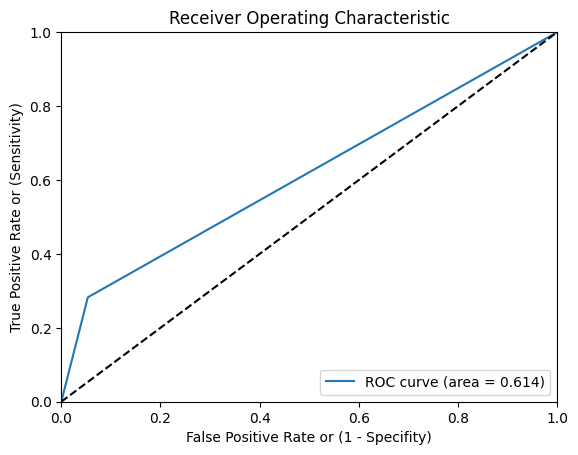

In [7]:
X, y = prepare_XY_set(df_data, Start_Date, End_date, Predict_date)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345, shuffle=True)
Build_and_Eval_models(X_train, X_test, y_train, y_test)

2011-09-29 00:00:00
2011-10-27 00:00:00
LogisticRegression [0.78961234 0.86112157]
GaussianNB [0.79262326 0.84230335]
RandomForestClassifier [0.77907414 0.83251788]
SVC [0.79224689 0.83778698]
DecisionTreeClassifier [0.7214904  0.80654874]
xgb.XGBClassifier [0.75498683 0.84004516]
KNeighborsClassifier [0.76815958 0.82536696]
Accuracy of Random Forest classifier on training set: 1.00
Accuracy of Random Forest classifier on test set: 0.80
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      4357
           1       0.52      0.31      0.39      1121

    accuracy                           0.80      5478
   macro avg       0.68      0.62      0.64      5478
weighted avg       0.77      0.80      0.78      5478

Accuracy of XGB classifier on training set: 0.96
Accuracy of XGB classifier on test set: 0.79
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      4357
           1       0.50      

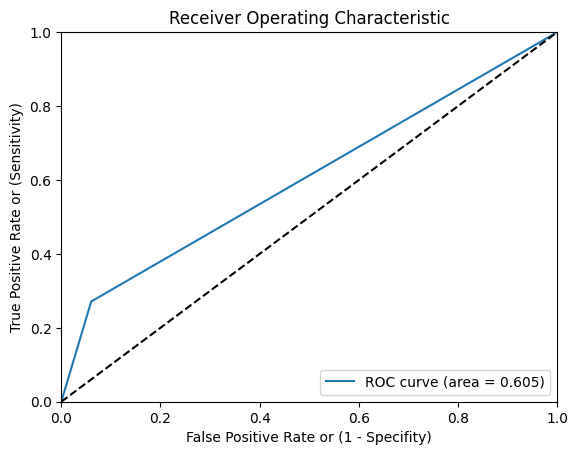

In [9]:
#случай с правильной валидацией
Start_Date = pd.Timestamp(2009,12,1)
End_date = pd.Timestamp(2011, 9,1)
#End_date = pd.Timestamp(2011, 6,1)
Days_to_predict = 28
Predict_date = End_date + pd.Timedelta(Days_to_predict,"d")
print(Predict_date)

X_train, y_train = prepare_XY_set(df_data, Start_Date, End_date, Predict_date)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345, shuffle=True)

End_date = Predict_date
Predict_date = End_date + pd.Timedelta(Days_to_predict,"d")
print(Predict_date)

X_test, y_test = prepare_XY_set(df_data, Start_Date, End_date, Predict_date)

Build_and_Eval_models(X_train, X_test, y_train, y_test)




# МОИ ИЗМЕНЕНИЯ - Ввод данных



## Ввод данных

In [10]:
my_data = pd.read_csv("./Data.csv")
my_data.rename(columns={'Invoice':'InvoiceNo', 'Customer ID':'CustomerID', 'Price':'UnitPrice'}, inplace=True)

my_data = my_data.dropna()
my_data.InvoiceDate = pd.to_datetime(my_data.InvoiceDate)
my_data['InvoiceYearMonth'] = my_data['InvoiceDate'].map(lambda date: 100*date.year + date.month)
my_data['Revenue'] = my_data.UnitPrice * my_data.Quantity
my_data = my_data[my_data.Quantity>0]

In [11]:
import importlib
%load_ext autoreload
%autoreload 2
from MySearch import *
from EventsPredict2 import *

In [12]:
Start_Date = pd.Timestamp(2009,12,1)
End_date = pd.Timestamp(2011, 9,1)
Days_to_predict = 28
Predict_date = End_date + pd.Timedelta(Days_to_predict,"d")

# сразу переходим к следующему интервалу
End_date = Predict_date
Predict_date = End_date + pd.Timedelta(Days_to_predict,"d")
Predict_date

Timestamp('2011-10-27 00:00:00')

In [13]:
train_dt = my_data[(my_data.InvoiceDate >= Start_Date) & (my_data.InvoiceDate < End_date)].reset_index(drop=True)
test_dt = my_data[(my_data.InvoiceDate >= End_date)  & (my_data.InvoiceDate < Predict_date)].reset_index(drop=True)


my_dt = pd.DataFrame(train_dt['CustomerID'].unique())
my_dt = my_dt.rename(columns={0:'CustomerID'})

my_dt['i'] = 0
my_dt['big'] = 0
my_dt['big_index'] = 0
my_dt['small'] = 0
my_dt['small_index'] = 0

my_dt['Tnm1'] = 0
my_dt['Tnm1f'] = 0
my_dt['Tn'] = 0
my_dt['Tnf'] = 0
my_dt['Tnp1'] = 0
my_dt['Tnp1f'] = 0

my_dt['Rnm1'] = 0
my_dt['Rnm1f'] = 0
my_dt['Rn'] = 0
my_dt['Rnf'] = 0
my_dt['Rnp1'] = 0
my_dt['Rnp1f'] = 0

my_dt['ErTnm1'] = 0
my_dt['ErTn'] = 0
my_dt['ErTnp1'] = 0

my_dt['ErRnm1'] = 0
my_dt['ErRn'] = 0
my_dt['ErRnp1'] = 0

my_dt['RelErTnm1'] = 0
my_dt['RelErTn'] = 0
my_dt['RelErTnp1'] = 0

my_dt['RelErRnm1'] = 0
my_dt['RelErRn'] = 0
my_dt['RelErRnp1'] = 0

my_dt['ScoreNm1'] = 0
my_dt['ScoreN'] = 0
my_dt['AvgScore'] = 0

#my_dt.head()

#Получение последовательности покупок каждого уникального покупателя
T = []
Y = []
T_next = []
Y_next = []
for customer in train_dt.CustomerID.unique():
    Ti = train_dt[(train_dt.CustomerID == customer)].groupby('InvoiceNo').InvoiceDate.unique()
    Yi = train_dt[(train_dt.CustomerID == customer)].groupby('InvoiceNo').Revenue.sum().to_numpy()
    T.append(Ti)#([x.to_numpy() for x in  Ti])
    Y.append(Yi)
    Ti = test_dt[(test_dt.CustomerID == customer)].groupby('InvoiceNo').InvoiceDate.unique()
    Yi = test_dt[(test_dt.CustomerID == customer)].groupby('InvoiceNo').Revenue.sum().to_numpy()
    if len(Ti)>0:
        T_next.append(Ti)#([x.to_numpy() for x in  Ti])
        Y_next.append(Yi)
    else:
        T_next.append(None)
        Y_next.append(None)

for customer in range(len(Y)):
    T0 = [T[customer][0][0]]
    Y0 = [Y[customer][0]]
    last_index = 0
    last_added_index = 0 
    for i in range(1,len(T[customer])):
        if ( T[customer][i][0] - T[customer][last_index][0] ).days == 0:
            Y0[last_added_index] += Y[customer][i]
            #print("i=", i,"; days == 0 ;", Y0)
        else :
            Y0=np.append(Y0, Y[customer][i])
            T0=np.append(T0, [T[customer][i][0]])
            last_index = i 
            last_added_index += 1
            #print("i=", i, "; days >= 0 ;", Y0)   
    T[customer] = T0
    Y[customer] = Y0
    my_dt.iat[customer, 1] = customer
    if last_added_index>0:
        my_dt.iat[customer, 6] = T[customer][last_added_index-1]
    my_dt.iat[customer, 8] = T[customer][last_added_index]  
    if last_added_index>0:
        my_dt.iat[customer, 12] = Y[customer][last_added_index-1]   
    my_dt.iat[customer, 14] = Y[customer][last_added_index]

    if T_next[customer] is not None:
        T0_next = [T_next[customer][0][0]]
        Y0_next = [Y_next[customer][0]]   
        last_index = 0
        last_added_index = 0 
        for i in range(1,len(T_next[customer])):
            if ( T_next[customer][i][0] - T_next[customer][last_index][0] ).days == 0:
                Y0_next[last_added_index] += Y_next[customer][i]
                #print("i=", i,"; days == 0 ;", Y0)
            else :
                Y0_next=np.append(Y0_next, Y_next[customer][i])
                T0_next=np.append(T0_next, [T_next[customer][i][0]])
                last_index = i 
                last_added_index += 1
                #print("i=", i, "; days >= 0 ;", Y0)       
        T_next[customer] = T0_next
        Y_next[customer] = Y0_next
        my_dt.iat[customer, 10] = T0_next[0]
        my_dt.iat[customer, 16] = Y0_next[0]


big_T = []
big_Y = []
small_T = []
small_Y = []
indexes = []
for i in range(len(Y)):
    T[i],Y[i] = Combine_same_dates( T[i], Y[i], n_days = 3 )
    T[i],Y[i] = Check_first( T[i], Y[i], n_means = 5 )
    if len(Y[i])>= 6:
        big_T.append(T[i])
        big_Y.append(Y[i])
        indexes.append(i)
        my_dt.iat[i, 2] = 1
        my_dt.iat[i, 3] = len(big_T)-1
    else:
        small_T.append(T[i])
        small_Y.append(Y[i])
        my_dt.iat[i, 4] = 1
        my_dt.iat[i, 5] = len(small_T)-1
print(len(big_T))
print(len(small_T))

my_dt['y_fut'] = False
my_dt['y_real'] = False
for i in range(len(my_dt)):
    if ( my_dt['CustomerID'].iloc[i] in test_dt['CustomerID'].unique() ):
        my_dt['y_real'].iloc[i] = True

my_dt['Score_next'] = False


my_dt.head()



1401
4015


,CustomerID,i,big,big_index,small,small_index,Tnm1,Tnm1f,Tn,Tnf,...,RelErTnp1,RelErRnm1,RelErRn,RelErRnp1,ScoreNm1,ScoreN,AvgScore,y_fut,y_real,Score_next
0,13085.0,0,0,0,1,0,2011-02-17 13:57:00,0,2011-07-05 12:11:00,0,...,0,0,0,0,0,0,0,False,False,False
1,13078.0,1,1,0,0,0,2011-09-14 11:55:00,0,2011-09-18 12:15:00,0,...,0,0,0,0,0,0,0,False,True,False
2,15362.0,2,0,0,1,1,2009-12-01 09:08:00,0,2010-09-17 10:37:00,0,...,0,0,0,0,0,0,0,False,False,False
3,18102.0,3,1,1,0,0,2011-09-22 10:48:00,0,2011-09-28 16:17:00,0,...,0,0,0,0,0,0,0,False,True,False
4,12682.0,4,1,2,0,0,2011-09-15 13:31:00,0,2011-09-19 12:19:00,0,...,0,0,0,0,0,0,0,False,True,False


In [16]:
my_dt.columns

Index(['CustomerID', 'i', 'big', 'big_index', 'small', 'small_index', 'Tnm1',
       'Tnm1f', 'Tn', 'Tnf', 'Tnp1', 'Tnp1f', 'Rnm1', 'Rnm1f', 'Rn', 'Rnf',
       'Rnp1', 'Rnp1f', 'ErTnm1', 'ErTn', 'ErTnp1', 'ErRnm1', 'ErRn', 'ErRnp1',
       'RelErTnm1', 'RelErTn', 'RelErTnp1', 'RelErRnm1', 'RelErRn',
       'RelErRnp1', 'ScoreNm1', 'ScoreN', 'AvgScore', 'y_fut', 'y_real',
       'Score_next'],
      dtype='object')

# Мой метод

## В цикле по клиентам

In [51]:
import importlib
%load_ext autoreload
%autoreload 2
from MySearch import *
from EventsPredict2 import *
import time


draw_plots = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Цикл ниже ипользовался при подготовке прогнозов для последующей записи в файл DataOut.csv,
# выполнение по всем клиентам занимает полтора дня, 
# код еще далеко не оптимизирован. 
# Выполнять его вам не обязательно, так как результат считывается из уже подготовленного файла.
# Этот цикл можно использовать для проверки отдельных записей, чтобы убедиться, что 
# файл DataOut.csv сформирован корректно.
# Для этого присвойте переменной index номер интересующей записи
# (номер содержиться в столбце big_index), 
# убедитесь, что в результате получается тот же прогноз, что и в файле DataOut.csv.
# Первый запуск будет достаточно долгим, так как выполняется компиляция 
# кода языка Python на более быстрый машинный язык с помощью библиотеки numba,
# последующие запуски будут намного быстрее, намного быстрее чем обычный Python код,
# без хотябы такой оптимизации, было бы совсем долго. 



In [27]:
index = 42

In [28]:
draw_plots = False

In [30]:

#for index in range(len(big_T) ): 
#for index in range(0,100): # подготовить первую сотню записей

for index in range(index,index+1):    
    
    print("<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<    index = ", index, "  >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
    t = big_T[index].copy()
    y = big_Y[index].copy() 
    t_start = t[0]
    t = np.array( [(x-t_start).days for x in t ] ) #np.array(  ) 
    n=len(t)
    t_next = T_next[indexes[index]]
    y_next = Y_next[indexes[index]]
    if t_next is not None:
        t_next =[(x-t_start).days for x in t_next ] #np.array(  ) 
    
    print("Исходные данные")
    print("n = ",n)
    print("Первое наблюдение из следующего квартала сделали тестовым")
    print("По выборке без последнего наблюдения подбираем параметры, чтобы предсказать это последнее наблюдение ")
    
    if t_next is not None:
        t_test = t_next[0] 
        y_test = y_next[0]
    else:
        t_test = None
        y_test = None
    
    t_train = t # 
    y_train = y
    
    print("t_train = ", t_train, " ; t_test = ", t_test)
    print("y_train = ", y_train, " ; y_test = ", y_test)
    
    n_predict = 200
    args = (t_train, y_train, n_predict)
    
    
    # ===== ОПТИМИЗАЦИЯ, подбирается коэффициент сглаживания alpha и число отбрасываемых дней при экстраполяции n1, n2 ======
    
    cvxopt.solvers.options['show_progress'] = False # не выводить сообщения
    
    L = t_train[1]-t_train[0]
    num_knots = min(10, max(1, L // 7 ) )
    n_width = L / num_knots
    n1_knots = []
    for i in range(num_knots+1):
        n1_knots.append(round(i*n_width))
        
    L = t_train[-1]-t_train[-2]
    num_knots = min(10, max(1,L // 7) )
    n_width = L / num_knots
    n2_knots = []
    for i in range(num_knots+1):
        n2_knots.append(round(i*n_width))
    
    each_axis_knots = [[10**3,10**4,10**5,10**6,10**7,10**8,10**9],
                       n1_knots,
                       n2_knots]
    print("each_axis_knots = ", each_axis_knots)
    is_int = np.array([False, True, True])

    start = time.perf_counter()
    res, Total_iterations, Total_calls = my_grid_search(Predict_and_score_parameters2_njit, 
                                                          *args,  
                                                          each_axis_knots = each_axis_knots, 
                                                          is_int = is_int, 
                                                          num_results = 30, 
                                                          overlap = 2,
                                                          max_iter=10000, 
                                                          abs_tol=0.000001 , 
                                                          rel_tol=0.000001)
    end = time.perf_counter()
    print("Время на итерацию = {}s".format((end - start)))
    print("Total_iterations = ", Total_iterations)
    print("Total_calls = ", Total_calls)

    if res == [] :
        print("Result list is empty")
        continue
    
    print("res = ")
    print(res[0])
    
    
    print("С теми же параметрами предсказываем t[-2]")
    T_future, Y_future = get_next_event(t[0:(n-2)], y[0:(n-2)] , n_predict, alpha = res[0][0][0], n1 = round(res[0][0][1]), n2 = round(res[0][0][2]), \
                                        draw_plots = draw_plots, print_info = True)
    
    if (T_future is not None) and (Y_future is not None):
        if (draw_plots):
            plt.scatter(t[-2],0, color="magenta")
        T_future_date = t_start + pd.Timedelta(T_future,"d")
        print("T_future_date = ", T_future_date) 
        
        Score1 = Calculate_score(T_future, Y_future, T_future_real = t[-2], T_pred_real = t[-3], Y_future_real = y[-2], print_info = True)
        print(Score1)   
        
        my_dt.iat[indexes[index] , 7 ] = T_future_date 
        my_dt.iat[indexes[index] , 13 ] = Y_future
        Error_t = T_future - t[-2]
        Error_t_rel = Error_t / (t[-2]- t[-3])       
        Error_Y = Y_future - y[-2]        
        Error_Y_rel = Error_Y / y[-2]
        my_dt.iat[indexes[index] , 18 ] = Error_t 
        my_dt.iat[indexes[index] , 24 ] = Error_t_rel
        my_dt.iat[indexes[index] , 21 ] = Error_Y 
        my_dt.iat[indexes[index] , 27 ] = Error_Y_rel
        my_dt.iat[indexes[index] , 30 ] = Score1
        
    else:
        print("!!! Prediction failed !!!")
        print("Event didnt happen with n_predict = ", n_predict, " try increase n_predict")
        #continue
    
    
    
    
    print("С теми же параметрами предсказываем t[-1]")
    T_future, Y_future = get_next_event( t[0:(n-1)], y[0:(n-1)] , n_predict, alpha = res[0][0][0], n1 = round(res[0][0][1]), n2 = round(res[0][0][2]),
                                        draw_plots = draw_plots, print_info = True)
    
    if (T_future is not None) and (Y_future is not None):
        if (draw_plots):
            plt.scatter(t[-1],0, color="magenta")
        T_future_date = t_start + pd.Timedelta(T_future,"d")
        print("T_future_date = ", T_future_date) 
        
        Score2 = Calculate_score(T_future, Y_future, T_future_real = t[-1], T_pred_real = t[-2], Y_future_real = y[-1], print_info = True)
        print(Score2)
        my_dt.iat[indexes[index] , 9 ] = T_future_date 
        my_dt.iat[indexes[index] , 15 ] = Y_future
        Error_t = T_future - t[-1]
        Error_t_rel = Error_t / (t[-1]- t[-2])       
        Error_Y = Y_future - y[-1]        
        Error_Y_rel = Error_Y / y[-1]
        my_dt.iat[indexes[index] , 19 ] = Error_t 
        my_dt.iat[indexes[index] , 25 ] = Error_t_rel
        my_dt.iat[indexes[index] , 22 ] = Error_Y 
        my_dt.iat[indexes[index] , 28 ] = Error_Y_rel
        my_dt.iat[indexes[index] , 31 ] = Score2
        my_dt.iat[indexes[index] , 32 ] = (Score1+Score2)/2
    else:
        print("!!! Prediction failed !!!")
        print("Event didnt happen with n_predict = ", n_predict, " try increase n_predict")
        #continue
    
    
    
    
    
    print("С теми же параметрами предсказываем t_next[0]")
    T_future, Y_future = get_next_event(t_train, y_train, n_predict, alpha = res[0][0][0], n1 = round(res[0][0][1]), n2 = round(res[0][0][2]), 
                                        draw_plots = draw_plots, print_info = True)
    
    if (T_future is not None) and (Y_future is not None):
        if (draw_plots):
            plt.scatter(t_test, 0, color="magenta")
        T_future_date = t_start + pd.Timedelta(T_future,"d")
        print("T_future_date = ", T_future_date) 
        
        my_dt.iat[indexes[index] , 11 ] = T_future_date 
        my_dt.iat[indexes[index] , 17 ] = Y_future
        
        mean_dt = np.mean(np.array(t_train[1:n])-np.array(t_train[0:(n-1)]) )
        if (T_future_date < Predict_date) and (T_future_date+pd.Timedelta( 5*mean_dt, "d") >= End_date): 
            my_dt.iat[indexes[index] , 33 ] = True
            print(" Predicted next event")
    
        
        if (t_test is not None) and (y_test is not None):
            Score3 = Calculate_score(T_future, Y_future, T_future_real = t_test, T_pred_real = t[-1], Y_future_real = y_test, print_info = True)
            print(Score3)
            
            Error_t = T_future - t_test
            Error_t_rel = Error_t / (t_test- t[-1])       
            Error_Y = Y_future - y_test       
            Error_Y_rel = Error_Y / y_test
            my_dt.iat[indexes[index] , 20 ] = Error_t 
            my_dt.iat[indexes[index] , 26 ] = Error_t_rel
            my_dt.iat[indexes[index] , 23 ] = Error_Y 
            my_dt.iat[indexes[index] , 29 ] = Error_Y_rel
            my_dt.iat[indexes[index] , 35 ] = Score3
        else:
            print(" Real event didnt happen")
    else:    
        print("!!! Prediction failed !!!")
        print("Event didnt happen with n_predict = ", n_predict, " try increase n_predict")
        #continue  


<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<    index =  42   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Исходные данные
n =  13
Первое наблюдение из следующего квартала сделали тестовым
По выборке без последнего наблюдения подбираем параметры, чтобы предсказать это последнее наблюдение 
t_train =  [  0  50  76 118 140 187 240 268 307 349 426 519 601]  ; t_test =  679
y_train =  [407.97 260.   340.35 405.   425.6  326.85 370.66 239.94 531.6  641.4
 846.69 814.71 451.13]  ; y_test =  497.83000000000004
each_axis_knots =  [[1000, 10000, 100000, 1000000, 10000000, 100000000, 1000000000], [0, 7, 14, 21, 29, 36, 43, 50], [0, 8, 16, 25, 33, 41, 49, 57, 66, 74, 82]]
Время на итерацию = 98.07283329999882s
Total_iterations =  18022
Total_calls =  78090
res = 
(array([1.07246595e+06, 4.00000000e+00, 2.90000000e+01]), 0.037058401812535634, True, 61, 269, 'Выполнилось условие остановки np.array_equal(Points_old, Points)')
С теми же параметрами предсказываем t[-2]
Delta_t =  93 , Storage =  -7.4772022970934735
T_f

In [36]:
print(my_dt[my_dt.big_index == 42])

    CustomerID   i  big  big_index  small  small_index                 Tnm1  \
64     12836.0  64    1         42      0            0  2011-05-04 15:08:00   

                  Tnm1f                   Tn                  Tnf  ...  \
64  2011-05-04 14:19:00  2011-07-25 15:22:00  2011-07-23 14:19:00  ...   

   RelErTnp1 RelErRnm1   RelErRn  RelErRnp1  ScoreNm1    ScoreN  AvgScore  \
64 -0.153846  -0.46145  0.035815  -0.063836  0.046145  0.027972  0.037058   

    y_fut  y_real  Score_next  
64   True    True     0.16023  

[1 rows x 36 columns]


In [50]:
# результаты оптимизации гиперпараметров, 30 лучших результатов
res

[(array([1.07246595e+06, 4.00000000e+00, 2.90000000e+01]),
  0.037058401812535634,
  True,
  61,
  269,
  'Выполнилось условие остановки np.array_equal(Points_old, Points)'),
 (array([9.76319847e+05, 9.00000000e+00, 3.40000000e+01]),
  0.043319225839594785,
  True,
  68,
  289,
  'Выполнилось условие остановки np.array_equal(Points_old, Points)'),
 (array([1.03726563e+06, 1.00000000e+01, 4.00000000e+00]),
  0.048513666527561325,
  True,
  57,
  274,
  'Выполнилось условие остановки np.array_equal(Points_old, Points)'),
 (array([1.18114983e+06, 1.50000000e+01, 3.20000000e+01]),
  0.0492336394760053,
  True,
  69,
  287,
  'Выполнилось условие остановки np.array_equal(Points_old, Points)'),
 (array([5500.,   26.,   45.]),
  0.04955921364508907,
  True,
  58,
  277,
  'Выполнилось условие остановки np.array_equal(Points_old, Points)'),
 (array([1.32182617e+06, 1.80000000e+01, 2.00000000e+00]),
  0.04977559981364438,
  True,
  65,
  274,
  'Выполнилось условие остановки np.array_equal(Poin

In [37]:
index = 42
draw_plots = True

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<    index =  42   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Исходные данные
n =  13
Первое наблюдение из следующего квартала сделали тестовым
По выборке без последнего наблюдения подбираем параметры, чтобы предсказать это последнее наблюдение 
t_train =  [  0  50  76 118 140 187 240 268 307 349 426 519 601]  ; t_test =  679
y_train =  [407.97 260.   340.35 405.   425.6  326.85 370.66 239.94 531.6  641.4
 846.69 814.71 451.13]  ; y_test =  497.83000000000004
Delta_t =  66 , Storage =  -4.464913189900164
T_future =  667
Y_future =  466.05066362389226
mean_dt =  50.083333333333336
T_future_date =  2011-09-29
T_future_date_real =  2011-09-29
ylim =  3.9485672985084372


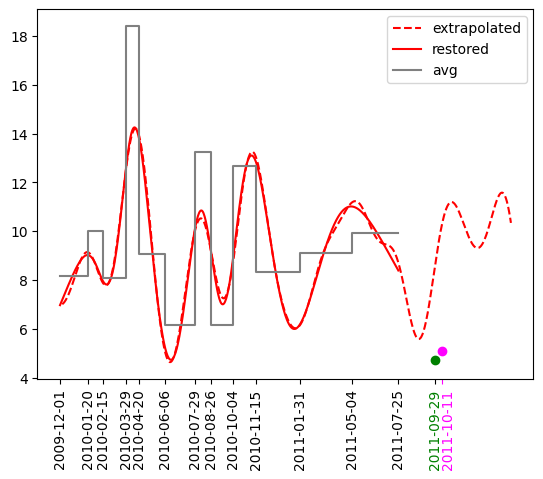

In [39]:
# Отдельно еще раз получение прогноза с оптимальными гиперпараметрами и вывод графика
print("<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<    index = ", index, "  >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
t = big_T[index].copy()
y = big_Y[index].copy() 
t_start = t[0]
t = np.array( [(x-t_start).days for x in t ] ) #np.array(  ) 
n=len(t)
t_next = T_next[indexes[index]]
y_next = Y_next[indexes[index]]
if t_next is not None:
    t_next =[(x-t_start).days for x in t_next ] #np.array(  ) 

print("Исходные данные")
print("n = ",n)
print("Первое наблюдение из следующего квартала сделали тестовым")
print("По выборке без последнего наблюдения подбираем параметры, чтобы предсказать это последнее наблюдение ")

if t_next is not None:
    t_test = t_next[0] 
    y_test = y_next[0]
else:
    t_test = None
    y_test = None

t_train = t # 
y_train = y

print("t_train = ", t_train, " ; t_test = ", t_test)
print("y_train = ", y_train, " ; y_test = ", y_test)

n_predict = 200
T_future, Y_future = get_next_event(t_train, y_train, n_predict, 
                                    alpha = res[0][0][0], n1 = round(res[0][0][1]), n2 = round(res[0][0][2]),
                                    #alpha = 10**5, n1 = 10, n2 = 10, 
                                    draw_plots = draw_plots, print_info = True)

T_future_date = (t_start + pd.Timedelta(T_future,"d")).date()
print("T_future_date = ", T_future_date)
T_future_date_real = (t_start + pd.Timedelta(t_next[0],"d")).date()
print("T_future_date_real = ", T_future_date) 

plt.xticks(ticks=list(t)+[T_future, t_next[0], t_next[0]+10],
           labels=[(t_start+pd.Timedelta(tx,"d")).date() for tx in t]+[T_future_date, '', T_future_date_real ], 
           rotation='vertical')
plt.gca().get_xticklabels()[-3].set_color("green")
plt.gca().get_xticklabels()[-2].set_color("magenta")
plt.gca().get_xticklabels()[-1].set_color("magenta")
plt.gca().xaxis.get_major_ticks()[-1]._apply_params(width = 0)
plt.gca().xaxis.get_major_ticks()[-2]._apply_params(color = "magenta")
#plt.gca().xaxis.get_major_ticks()[-1].ticks.set_visible(False)

#plt.xticks(ticks=[T_future], labels=[(t_start+pd.Timedelta(T_future,"d")).date()], rotation='vertical', color="red")

plt.scatter(t_next[0], 5.1, color="magenta")
print("ylim = ", plt.ylim()[0])

plt.legend()
plt.show()
#index = index + 1

In [23]:
# Сохранение результатов расчета в файл
# my_dt[my_dt.big == 1].to_csv("./DataOut.csv")

# Работа с результатами

In [40]:
my_dt2 = pd.read_csv("./DataOut.csv", sep=";", decimal=',')

In [41]:
my_dt2 = my_dt2[ (my_dt2.ScoreNm1 <= 0.06) & (my_dt2.ScoreN <= 0.06) ]
my_dt2

,CustomerID,i,big,big_index,small,small_index,Tnm1,Tnm1f,Tn,Tnf,...,RelErTnp1,RelErRnm1,RelErRn,RelErRnp1,ScoreNm1,ScoreN,AvgScore,y_fut,y_real,Score_next
11,15311,20,1,11,0,0,23.09.2011 11:22,21.09.2011 11:21,27.09.2011 12:17,27.09.2011 11:21,...,-0.166667,0.409715,0.572368,0.624490,0.040971,0.057237,0.049104,True,True,"0,22911566"
16,14871,28,1,16,0,0,29.03.2011 13:22,29.03.2011 11:57,14.06.2011 13:04,14.06.2011 11:57,...,0.000000,0.296854,0.284569,0.000000,0.029685,0.028457,0.029071,True,False,False
23,14341,35,1,23,0,0,31.07.2011 10:48,07.05.2011 12:20,01.08.2011 14:05,29.07.2011 12:20,...,-0.344828,-0.111552,-0.231730,-0.665319,0.020864,0.035221,0.028043,True,True,"0,411359479"
27,15719,40,1,27,0,0,05.08.2011 12:27,05.08.2011 12:47,01.09.2011 12:41,31.08.2011 12:47,...,0.361111,-0.090553,-0.389931,-0.121350,0.043538,0.038993,0.041266,True,True,"0,373246158"
29,15793,42,1,29,0,0,26.11.2010 10:36,25.11.2010 12:54,16.03.2011 10:45,14.03.2011 12:54,...,0.000000,-0.108185,-0.067536,0.000000,0.010818,0.015844,0.013331,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1369,16678,4547,1,1369,0,0,12.08.2011 16:07,12.08.2011 9:24,02.09.2011 10:24,02.09.2011 9:24,...,0.000000,-0.208092,-0.125911,0.000000,0.020809,0.012591,0.016700,True,False,False
1370,17652,4558,1,1370,0,0,18.07.2011 14:04,17.07.2011 14:05,16.09.2011 14:39,16.09.2011 14:05,...,1.250000,0.260702,-0.031876,0.110669,0.026070,0.003188,0.014629,True,True,"1,26106695"
1374,12901,4612,1,1374,0,0,23.08.2011 10:56,24.08.2011 10:41,19.09.2011 13:39,19.09.2011 10:41,...,0.769231,0.071745,-0.467029,0.397539,0.047175,0.046703,0.046939,False,True,"0,808984626"
1375,12955,4626,1,1375,0,0,19.07.2011 10:49,19.07.2011 9:03,08.09.2011 12:48,08.09.2011 9:03,...,0.450000,-0.276823,-0.444516,0.149122,0.027682,0.044452,0.036067,False,True,"0,464912156"


In [42]:
print(classification_report( my_dt2['y_real'], my_dt2['y_fut'] ))


              precision    recall  f1-score   support

       False       0.70      0.52      0.60       121
        True       0.53      0.71      0.61        93

    accuracy                           0.60       214
   macro avg       0.62      0.62      0.60       214
weighted avg       0.63      0.60      0.60       214



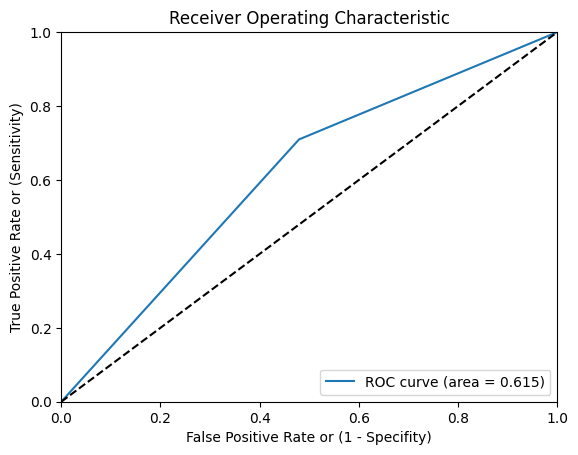

In [43]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(my_dt2['y_real'],my_dt2['y_fut'])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Сравнение с ранее оцененной моделью только по эквивалентной выборке

2011-09-29 00:00:00
2011-10-27 00:00:00
LogisticRegression [0.41747573 0.60784314]
GaussianNB [0.72815534 0.66666667]
RandomForestClassifier [0.41747573 0.6372549 ]
SVC [0.7184466  0.59803922]
DecisionTreeClassifier [0.36893204 0.6372549 ]
xgb.XGBClassifier [0.45631068 0.61764706]
KNeighborsClassifier [0.58252427 0.67647059]
Accuracy of Random Forest classifier on training set: 1.00
Accuracy of Random Forest classifier on test set: 0.62
              precision    recall  f1-score   support

           0       0.64      0.72      0.68       120
           1       0.57      0.49      0.53        94

    accuracy                           0.62       214
   macro avg       0.61      0.60      0.60       214
weighted avg       0.61      0.62      0.61       214

Accuracy of XGB classifier on training set: 1.00
Accuracy of XGB classifier on test set: 0.56
              precision    recall  f1-score   support

           0       0.60      0.67      0.63       120
           1       0.50      

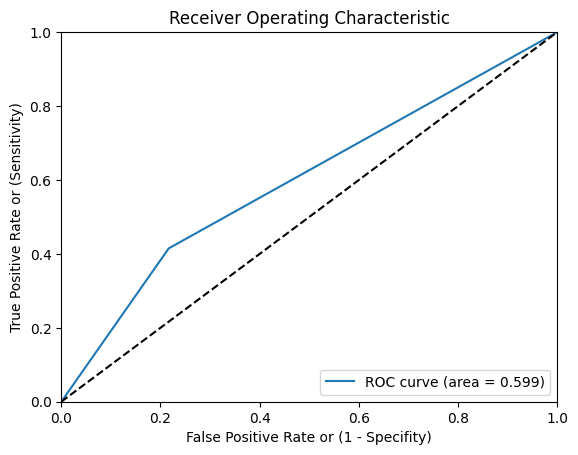

In [49]:
Start_Date = pd.Timestamp(2009,12,1)
End_date = pd.Timestamp(2011, 9,1)
Days_to_predict = 28
Predict_date = End_date + pd.Timedelta(Days_to_predict,"d")
print(Predict_date)


X_train, y_train = prepare_XY_set(df_data, Start_Date, End_date, Predict_date)

End_date = Predict_date
Predict_date = End_date + pd.Timedelta(Days_to_predict,"d")
print(Predict_date)

X_test, y_test = prepare_XY_set(df_data, Start_Date, End_date, Predict_date)

mask = X_test.CustomerID.isin( my_dt2['CustomerID'].unique() )

Build_and_Eval_models(X_train[mask].drop('CustomerID', axis=1),
                      X_test[mask].drop('CustomerID', axis=1),
                      y_train[mask],
                      y_test[mask])

In [45]:
sum(mask)

214